In [1]:
"""
Created on Wed Sep 27 

@author: paola 

Calculate the luminosity normalized that we will use in the blue (BB) curve.

NOTES FOR OTHERS:
- All the functions have to be applied to a CELL
- arguments are in cgs, NOT in log.
"""

'\nCreated on Wed Sep 27 \n\n@author: paola \n\nCalculate the luminosity normalized that we will use in the blue (BB) curve.\n\nNOTES FOR OTHERS:\n- All the functions have to be applied to a CELL\n- arguments are in cgs, NOT in log.\n'

In [2]:
# Vanilla imports
import numpy as np
import matplotlib.pyplot as plt

# Chocolate imports
from src.Luminosity.photosphere import get_photosphere
from src.Optical_Depth.opacity_table import opacity

# Constants
c = 2.9979e10 #[cm/s]
h = 6.6261e-27 #[gcm^2/s]
Kb = 1.3806e-16 #[gcm^2/s^2K]
alpha = 7.5646 * 10**(-15) # radiation density [erg/cm^3K^4]
Rsol_to_cm = 6.957e10


In [3]:
# VARIABLES: frequencies [Hz]
n_min = 1e12 
n_max = 1e18
n_spacing = 10000
#n_array = np.linspace(n_min, n_max, num = n_spacing)
#n_logspace = np.log10(n_array)
n_linear_in_log = np.linspace(np.log10(n_min), np.log10(n_max), num = n_spacing)

In [4]:
# FUNCTIONS

def select_fix(m):
    if m == 4:
        snapshots = np.arange(233,263+1)
        days = [1.015, 1.025, 1.0325, 1.0435, 1.0525, 1.06, 1.07, 1.08, 1.0875, 1.0975, 1.1075, 1.115, 1.125, 1.135, 1.1425, 1.1525, 1.1625, 1.17, 1.18, 1.19, 1.1975, 1.2075, 1.2175, 1.2275, 1.235, 1.245, 1.255, 1.2625, 1.2725, 1.2825, 1.29] #t/t_fb
    if m == 6:
        snapshots = [844, 881, 925, 950, 1006]
        days = [1.00325, 1.13975, 1.302, 1.39425, 1.60075] #t/t_fb
    return snapshots, days

def emissivity(Temperature, Density, cell_vol):
    """ Gives emissivity in a cell. """
    k_planck = opacity(Temperature, Density, 'planck', ln = False)
    emiss = alpha * c * Temperature**4 * k_planck * cell_vol
    return emiss

def planck_fun_n_cell(Temperature: float, n: float) -> float:
    """ Planck function in a cell. """
    const = 2*h/c**2
    fun = const * n**3 / (np.exp(h*n/(Kb*Temperature))-1)
    return fun

In [5]:
s,d = select_fix(4)
len(d)

31

In [6]:
# Check how plots look: use n_array AND THEN LOGLOG

# fig, axs = plt.subplots(1,2)
# fig.subplots_adjust(wspace = 0.5)
# axs[0].plot(n_array, planck_fun_n_cell(1e6, n_array))
# axs[0].set_title('n_array')
# axs[0].loglog()
# axs[1].plot(n_logspace, planck_fun_n_cell(1e6, n_array))
# axs[1].set_title('n_logspace')
# axs[1].set_yscale('log')

# print(find_peak(1e6))

In [7]:
# def real_planck_fun_cell(Temperature: float) -> float:
#     """
#     Bolometric planck function in a cell B(T) without changing integrand.
#     """
#     n_Bn_array = []
    
#     for n in n_array:
#         n_Bn = planck_fun_n_cell(Temperature, n)
#         n_Bn_array.append(n_Bn)
        
#     # Integrate
#     n_Bn_array = np.array(n_Bn_array) # Make arr, to intergrate
#     fun = np.trapz(n_Bn_array, n_array)
#     return fun


In [8]:
# def planck_fun_cell(Temperature: float) -> float:
#     """
#     Bolometric planck function in a cell: B(T).
#     """
#     n_Bn_array = []
    
#     for n in n_array:
#         n_Bn = n * planck_fun_n_cell(Temperature, n)
#         n_Bn_array.append(n_Bn)
        
#     # Integrate
#     n_Bn_array = np.array(n_Bn_array) # Make arr, to intergrate
#     fun = np.trapz(n_Bn_array, n_logspace)
#     return fun

In [9]:
# # Check the mess with integration of B: almost the same thus we don't have problem integrating beyond the peak
# def test_peak(Temperature: float) -> float:
#     """
#     Bolometric planck function in a cell: B(T).
#     """
#     n_Bn_array = []
#     peak = find_peak(Temperature)
    
#     for n in n_array:
#         if n > peak:
#             n_Bn = 0 
#         else:
#             n_Bn = n * old_planck_fun_n_cell(Temperature, n)
#         n_Bn_array.append(n_Bn)
        
#     # Integrate
#     n_Bn_array = np.array(n_Bn_array) # Make arr, to intergrate
#     fun = np.trapz(n_Bn_array, n_logspace)
#     return fun

# a = old_planck_fun_cell(1e6)
# b = test_peak(1e6)
# print("B all frequencies: ", a)
# print("B cut at the peak: ", b)

In [10]:
# Is it correct to use n_logspace? Almost, but no because the interval don't match. We define our trapz
def hand_integration(fun, arr):
    """ Apply trapz rule on fun = f(arr) for not evenly space x"""
    F = 0
    
    for i in range(1,len(arr)):
        delta_x = arr[i]-arr[i-1]
        f_step = (fun[i] + fun[i-1]) * delta_x / 2
        F += f_step
        
    return F

In [11]:
# def luminosity_n(Temperature: float, Density: float, tau: float, volume: float, n:int):
#     """ Luminosity in a cell. """
#     epsilon = emissivity(Temperature, Density, volume)
#     lum_cell = epsilon * planck_fun_n_cell(Temperature, n) * np.exp(-tau)
#     return (lum_cell/planck_fun_cell(Temperature))
    

In [12]:
def Elena_luminosity_n(Temperature: float, Density: float, tau: float, volume: float, n:int):
    k_planck = opacity(Temperature, Density, 'planck', ln = False)
    L = 4 * np.pi * k_planck * volume * np.exp(-tau) * planck_fun_n_cell(Temperature, n)
    return L

In [13]:
def final_normalisation(L_n: np.array, luminosity_fld: float) -> float:
    """ Given the array of luminosity L_n computed over 10^{n_lin_in_log} (!!!), find the normalisation constant from FLD model used for L_tilde_nu. """  
    n_L_n = np.log(10) * 10**(n_linear_in_log) * L_n
    L = np.trapz(n_L_n, n_linear_in_log) 
    norm = luminosity_fld / L
    return norm

In [14]:
# def TEST_final_norm(L_n: np.array, luminosity_fld: float):
#     L = np.trapz(L_n, n_array)
#     norm = luminosity_fld / L
#     return  norm

In [15]:
# def final_normalisation(L_n: np.array, luminosity_fld: float) -> float:
#     """ Given the array of luminosity L_n computed over n_array (!!!), find the normalisation constant from FLD model used for L_tilde_nu. """  
#     n_L_n = np.log(10) * n_array * L_n
#     L = np.trapz(n_L_n, n_logspace) 
#     norm = luminosity_fld / L
#     return norm

# OLD MAIN
# if __name__ == "__main__":
#     m = 4
#     fix_index = 0

#     snapshots, days = select_fix(m)
#     fld_data = np.loadtxt('reddata_m'+ str(m) +'.txt')
#     fix = snapshots[fix_index]
#     luminosity_fld_fix = fld_data[1]
#     rays_den, rays_T, rays_tau, photosphere, radii = get_photosphere(fix, m)
#     dr = (radii[1] - radii[0]) * Rsol_to_cm
#     volume = 4 * np.pi * radii**2 * dr  / 192

#     lum_n = np.zeros(len(n_logspace))
#     for j in range(len(rays_den)):
#         for i in range(len(rays_tau[j])):        
#             # Temperature, Density and volume: np.array from near to the BH to far away. Thus we will use negative index in the for loop.
#             # tau: np.array from outside to inside.      
#             T = rays_T[j][-i]
#             rho = rays_den[j][-i] 
#             opt_depth = rays_tau[j][i]
#             cell_vol = volume[-i]

#             # Ensure we can interpolate
#             rho_low = np.exp(-22)
#             T_low = np.exp(8.77)
#             T_high = np.exp(17.8)
#             if rho < rho_low or T < T_low or T > T_high:
#                 continue

#             for n_index in range(len(n_array)):
#                 # lum_n_cell = luminosity_n(T, rho, opt_depth, cell_vol, n_array[n_index])
#                 lum_n_cell = Elena_luminosity_n(T, rho, opt_depth, cell_vol, n_array[n_index])
#                 lum_n[n_index] += lum_n_cell
        
#         # print('ray:', j)

#     # Normalisation
#     const_norm = final_normalisation(lum_n, luminosity_fld_fix[fix_index])
#     #const_norm = TEST_final_norm(lum_n, luminosity_fld_fix[fix_index])
#     lum_tilde_n = lum_n *  const_norm

In [16]:
# MAIN
if __name__ == "__main__":
    m = 4
    fix_index = 18

    snapshots, days = select_fix(m)
    fld_data = np.loadtxt('reddata_m'+ str(m) +'.txt')
    fix = snapshots[fix_index]
    luminosity_fld_fix = fld_data[1]
    rays_den, rays_T, rays_tau, photosphere, radii = get_photosphere(fix, m)
    dr = (radii[1] - radii[0]) * Rsol_to_cm
    volume = 4 * np.pi * radii**2 * dr  / 192

    lum_n = np.zeros(len(n_linear_in_log))
    for j in range(len(rays_den)):
        for i in range(len(rays_tau[j])):        
            # Temperature, Density and volume: np.array from near to the BH to far away. Thus we will use negative index in the for loop.
            # tau: np.array from outside to inside.      
            T = rays_T[j][-i]
            rho = rays_den[j][-i] 
            opt_depth = rays_tau[j][i]
            cell_vol = volume[-i]

            # Ensure we can interpolate
            rho_low = np.exp(-22)
            T_low = np.exp(8.77)
            T_high = np.exp(17.8)
            if rho < rho_low or T < T_low or T > T_high:
                continue
            
            for n_index in range(len(n_linear_in_log)): #we need linearspace
                # lum_n_cell = luminosity_n(T, rho, opt_depth, cell_vol, n_array[n_index])
                freq = 10**n_linear_in_log[n_index]
                lum_n_cell = Elena_luminosity_n(T, rho, opt_depth, cell_vol, freq)
                lum_n[n_index] += lum_n_cell
        
        # print('ray:', j)

    # Normalisation
    const_norm = final_normalisation(lum_n, luminosity_fld_fix[fix_index])
    #const_norm = TEST_final_norm(lum_n, luminosity_fld_fix[fix_index])
    lum_tilde_n = lum_n *  const_norm

/Users/paolamartire/miniconda3/envs/tde_comparison/lib/python3.9/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'observers' of function 'THE_SPHERICAL_CASTER'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "src/Calculators/spherical_caster.py", line 41:
@numba.njit
def THE_SPHERICAL_CASTER(radii, R,
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/paolamartire/miniconda3/envs/tde_comparison/lib/python3.9/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'observers' of function 'THE_SPHERICAL_CASTER'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#depreca

Shape Ray: (192, 350)


/Users/paolamartire/tde_comparison/src/Luminosity/photosphere.py:61: RuntimeWarning: divide by zero encountered in log
  logT = np.log(T)
/Users/paolamartire/tde_comparison/src/Luminosity/photosphere.py:63: RuntimeWarning: divide by zero encountered in log
  logrho = np.log(rho)
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_83242/1567479886.py:21: RuntimeWarning: overflow encountered in exp
  fun = const * n**3 / (np.exp(h*n/(Kb*Temperature))-1)


In [17]:
fin_int = np.log(10) * 10**(n_linear_in_log) * lum_tilde_n
# check = np.trapz(fin_int, n_linear_in_log)
check = hand_integration(fin_int, n_linear_in_log)
check="{:.2e}".format(check) #scientific notation
print('bolometric L', check)

bolometric L 3.91e+41


In [18]:
with open('Ltilda_m'+ str(m) + '.txt', 'a') as f:
   # f.write(' '.join(map(str, n_linear_in_log)) + '\n')
    f.write('#snap '+ str(fix) + ' L_tilde_n \n')
    f.write(' '.join(map(str, lum_tilde_n)) + '\n')
    f.close()

In [19]:
with open('L_m' + str(m) + '.txt', 'a') as fbolo:
    fbolo.write('#snap '+ str(fix) + '\n')
    fbolo.write(check + '\n')
    fbolo.close()

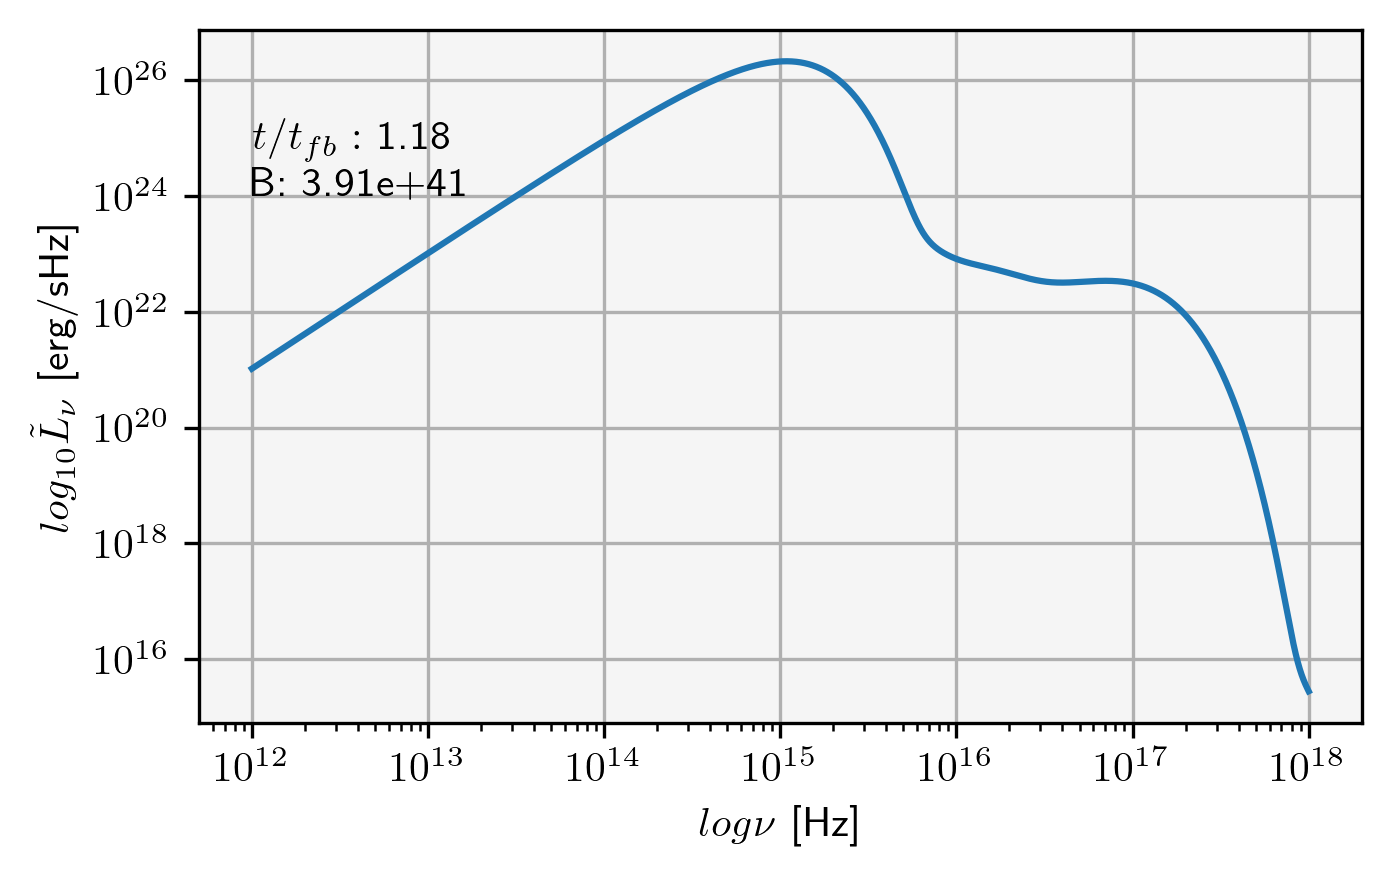

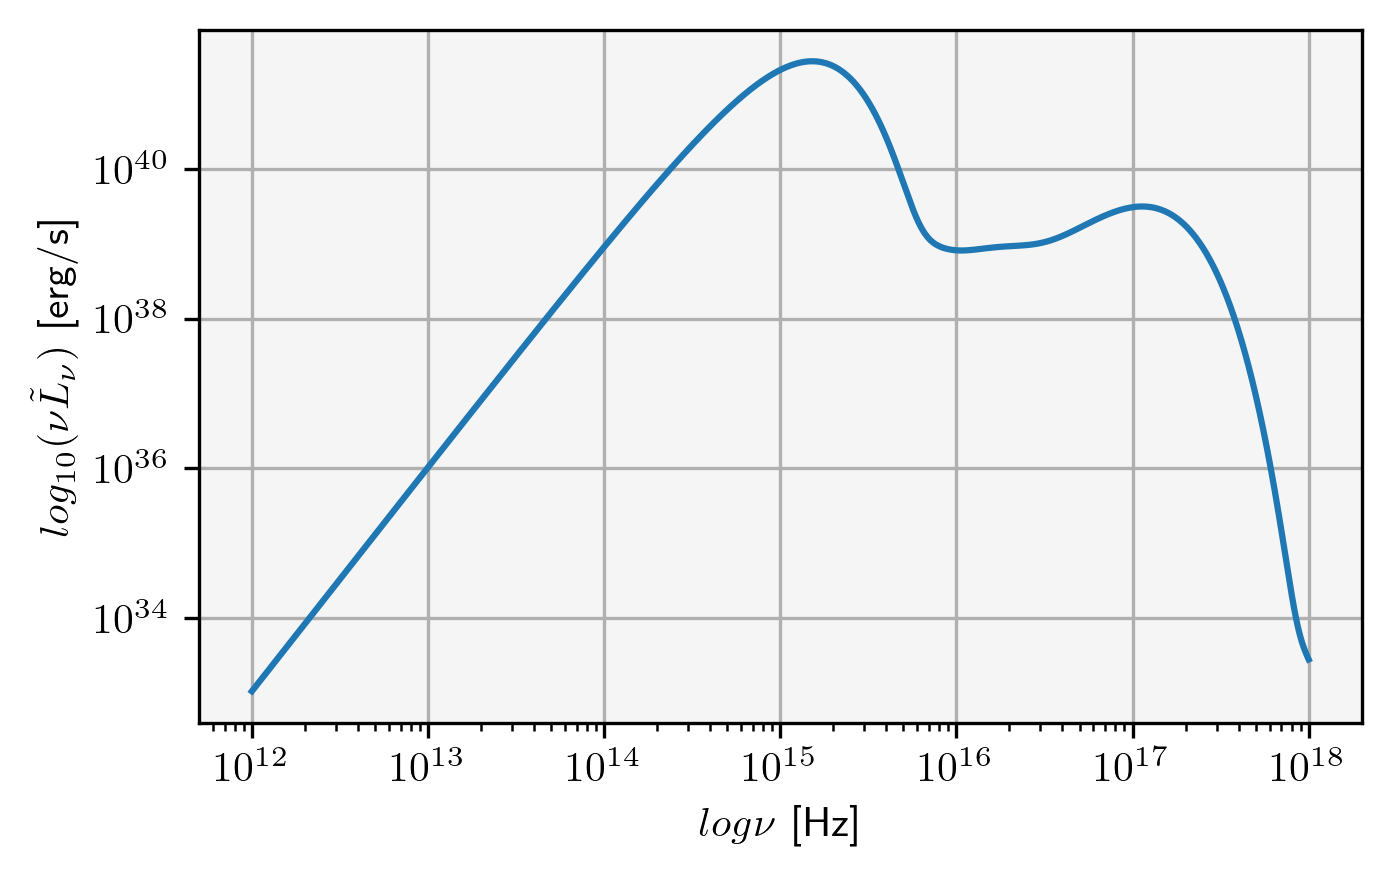

In [21]:
fig, ax = plt.subplots()
ax.plot(10**n_linear_in_log, lum_tilde_n)
plt.xlabel(r'$log\nu$ [Hz]')
plt.ylabel(r'$log_{10}\tilde{L}_\nu$ [erg/sHz]')
plt.loglog()
plt.grid()
plt.text(1e12, 1e24, r'$t/t_{fb}:$ ' + f'{days[fix_index]}\n B: {check}')
# plt.legend()
plt.savefig('Ltildan_m' + str(m) + '_snap' + str(fix))
plt.show()
ax.axvline(15, color = 'tab:orange')
ax.axvline(17, color = 'tab:orange')
ax.axvspan(15, 17, alpha=0.5, color = 'tab:orange')


plt.figure()
plt.plot(10**n_linear_in_log, 10**n_linear_in_log * lum_tilde_n)
plt.xlabel(r'$log\nu$ [Hz]')
plt.ylabel(r'$log_{10}(\nu\tilde{L}_\nu)$ [erg/s]')
plt.loglog()
plt.grid()
plt.savefig('n_Ltildan_m' + str(m) + '_snap' + str(fix))
plt.show()